# Modelling
In this part we experiment with differernt models and strive to get the best performing model

## Import the necessary libraries


In [1]:
# Set configuration for notebook
import os

os.chdir("c:\\Users\\Spectra\\flood-prediction")
os.getcwd()

'c:\\Users\\Spectra\\flood-prediction'

In [2]:
# Import libraries
import mlflow
import optuna
import pandas as pd
import numpy as np
import autogluon as ag
from autogluon.tabular import TabularDataset, TabularPredictor
from src.utils import load_config
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

In [3]:
# load config
config = load_config()

## Modelling

**Run automl to get the best model from which we can build upon**

In [4]:
# Load data
train_data = pd.read_csv(config["data"]["train_data_v2"])
label = "Flood"


# Split the data into train and validation sets
train, val = train_test_split(
    train_data, test_size=0.1, stratify=train_data[label], random_state=42
)
train = TabularDataset(train)
val = TabularDataset(val)
# Run AutoML with stratified cross-validation
predictor = TabularPredictor(
    label=label, eval_metric="f1", sample_weight="auto_weight"
).fit(train_data, presets=["medium_quality", "optimize_for_deployment"])

# Get the leaderboard of models
predictor.leaderboard(val)

No path specified. Models will be saved in: "AutogluonModels\ag-20240527_115602"
Presets specified: ['medium_quality', 'optimize_for_deployment']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240527_115602"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Memory Avail:       2.61 GB / 15.85 GB (16.5%)
Disk Space Avail:   96.26 GB / 475.53 GB (20.2%)
Train Data Rows:    26433
Train Data Columns: 6
Label Column:       Flood
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0.0, 1.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Problem Type:       binary
Prepro

model  score_test  score_val eval_metric  pred_time_test  \
0       KNeighborsDist    0.966862   0.657592          f1        0.042744   
1  WeightedEnsemble_L2    0.853387   0.747826          f1        0.065744   
2             LightGBM    0.809237   0.745435          f1        0.015999   

   pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0       0.145689  0.206665                 0.042744                0.145689   
1       0.176689  4.706896                 0.007001                0.003999   
2       0.027001  3.263970                 0.015999                0.027001   

   fit_time_marginal  stack_level  can_infer  fit_order  
0           0.206665            1       True          1  
1           1.236261            2       True          3  
2           3.263970            1       True          2

In [6]:
predictor.path

'AutogluonModels\\ag-20240522_034459'

In [7]:
import shutil

In [8]:
shutil.move(predictor.path, "models/best_model")

'models/best_model'

In [264]:
predictor = TabularPredictor.load(config["models"]["models_directory"])

predictor.feature_importance(val)

Computing feature importance via permutation shuffling for 8 features using 1644 rows with 5 shuffle sets...
	17.68s	= Expected runtime (3.54s per shuffle set)
	4.82s	= Actual runtime (Completed 5 of 5 shuffle sets)


importance    stddev       p_value  n  p99_high   p99_low
Rainfall          0.196502  0.002994  6.463007e-09  5  0.202666  0.190338
rain_latitude     0.134218  0.005535  3.463299e-07  5  0.145615  0.122821
Station_Number    0.063042  0.005205  5.524884e-06  5  0.073758  0.052325
ALT               0.063004  0.002460  2.784880e-07  5  0.068070  0.057938
rain_longitude    0.059763  0.006247  1.412137e-05  5  0.072626  0.046900
dist_to_water     0.056144  0.005500  1.091452e-05  5  0.067469  0.044819
Min_Temp          0.030790  0.004926  7.602393e-05  5  0.040933  0.020647
Cloud_Coverage    0.028832  0.004601  7.528030e-05  5  0.038306  0.019357

Computing feature importance via permutation shuffling for 8 features using 1644 rows with 5 shuffle sets...


	9.44s	= Expected runtime (1.89s per shuffle set)
	5.8s	= Actual runtime (Completed 5 of 5 shuffle sets)


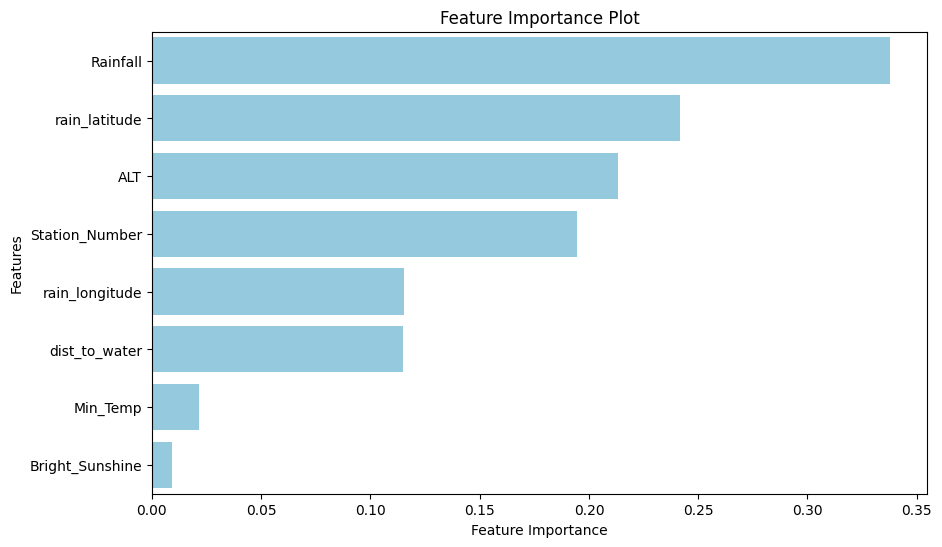

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance_df = predictor.feature_importance(val)
# Assuming 'df' is your DataFrame containing the feature importance data
plt.figure(figsize=(10, 6))
sns.barplot(
    x="importance",
    y=feature_importance_df.index,
    data=feature_importance_df,
    color="skyblue",
)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()

**Hyperparametertune the model**

**Validate Model on test data**

In [18]:
predictor = TabularPredictor.load(config["modelling"]["models_directory"])

In [7]:
# Load test data
predictor = TabularPredictor.load("AutogluonModels/ag-20240527_115602")
test_data = pd.read_csv(config["data"]["test_data_v2"]).drop("Flood", axis=1)
y_true = pd.read_csv(config["data"]["test_data_v2"])["Flood"].values
test = TabularDataset(config["data"]["test_data_v2"])
test_no_label = TabularDataset(test_data)

Loaded data from: data/testing_data/test_v2.csv | Columns = 7 / 7 | Rows = 2937 -> 2937


In [8]:
predictions = predictor.predict(test_no_label)

In [9]:
perf = predictor.evaluate(test, auxiliary_metrics=False)
perf

{'f1': 0.751147842056933}

In [10]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      2366
         1.0       0.79      0.72      0.75       571

    accuracy                           0.91      2937
   macro avg       0.86      0.84      0.85      2937
weighted avg       0.91      0.91      0.91      2937



The best model is saved in the folder models.

In [4]:
import os


def print_directory_tree(root_dir):
    print(f"{root_dir}/")
    for root, dirs, files in os.walk(root_dir):
        level = root.replace(root_dir, "").count(os.sep)
        indent = " " * 4 * level
        subdir = root.split("/")[-1]
        print(f"{indent}├── {subdir}/")
        for file in files:
            print(f"{indent}│   └── {file}")


# Example usage
print_directory_tree("flood-prediction")

flood-prediction/
